In [1]:
# https://machinelearningmastery.com/how-to-develop-a-probabilistic-forecasting-model-to-predict-air-pollution-days/


# Following Ensemble Tree Prediction Models

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [19]:
# load dataset
data = pd.read_csv('uci_ozone_data/eighthr.data', header=None, index_col=0, parse_dates=True, squeeze=True)
print(data.shape)
# summarize class counts
counts = data.groupby(data.shape[1]).size()
print(len(counts))
print(counts)
for i in range(len(counts)):
	percent = counts[i] / data.shape[0] * 100
	print('Class=%d, total=%d, percentage=%.3f' % (i, counts[i], percent))

(2534, 73)
2
73
0.0    2374
1.0     160
dtype: int64
Class=0, total=2374, percentage=93.686
Class=1, total=160, percentage=6.314


In [4]:
data.head()

,1,2,3,4,5,6,7,8,9,10,...,64,65,66,67,68,69,70,71,72,73
0,,,,,,,,,,,,,,,,,,,,,
1998-01-01,0.8,1.8,2.4,2.1,2,2.1,1.5,1.7,1.9,2.3,...,0.15,10.67,-1.56,5795,-12.1,17.9,10330,-55,0,0.0
1998-01-02,2.8,3.2,3.3,2.7,3.3,3.2,2.9,2.8,3.1,3.4,...,0.48,8.39,3.84,5805,14.05,29,10275,-55,0,0.0
1998-01-03,2.9,2.8,2.6,2.1,2.2,2.5,2.5,2.7,2.2,2.5,...,0.6,6.94,9.8,5790,17.9,41.3,10235,-40,0,0.0
1998-01-04,4.7,3.8,3.7,3.8,2.9,3.1,2.8,2.5,2.4,3.1,...,0.49,8.73,10.54,5775,31.15,51.7,10195,-40,2.08,0.0
1998-01-05,2.6,2.1,1.6,1.4,0.9,1.5,1.2,1.4,1.3,1.4,...,?,?,?,?,?,?,?,?,0.58,0.0


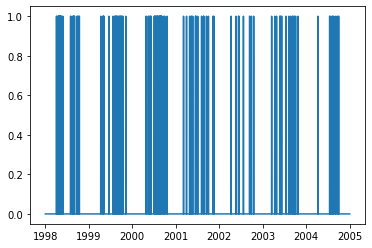

In [5]:
# plot the data
plt.plot(data.index, data.values[:, -1])
plt.show()

We can see that there are clusters of ozone days in the middle of each year: the summer or warmer months in the northern hemisphere.

From briefly reviewing the observations, we can get some ideas of how we might prepare the data:

- Missing data requires handling.
- The simplest framing is to predict ozone day tomorrow based on observations today.
- Temperature is likely correlated with season or time of year and may be a useful predictor.
- Data variables may require scaling (normalization) and perhaps even standardization depending on the algorithm chosen.
- Predicting probabilities will provide more nuance than predicting class values.
- Perhaps we can use five years (about 72%) to train a model and test it on the remaining two years (about 28%)

In [11]:
len(values)

2534

In [15]:
values = data.values
# replace missing observations with 0
values[values=='?'] = 0.0
print(values[1])
X1, y1 = values[1, :-1], values[2,-1]
print(X1)
print(y1)
row1 = np.hstack((X1,y1))
print(len(row1))

['2.8' '3.2' '3.3' '2.7' '3.3' '3.2' '2.9' '2.8' '3.1' '3.4' '4.2' '4.5'
 '4.5' '4.3' '5.5' '5.1' '3.8' '3' '2.6' '3' '2.2' '2.3' '2.5' '2.8' '5.5'
 '3.4' '15.1' '15.3' '15.6' '15.6' '15.9' '16.2' '16.2' '16.2' '16.6'
 '17.8' '19.4' '20.6' '21.2' '21.8' '22.4' '22.1' '20.8' '19.1' '18.1'
 '17.2' '16.5' '16.1' '16' '16.2' '22.4' '17.8' '9' '0.25' '-0.41' '9.53'
 '1594.5' '-2.2' '0.96' '8.24' '7.3' '3172' '-14.5' '0.48' '8.39' '3.84'
 '5805' '14.05' '29' '10275' '-55' '0' 0.0]
['2.8' '3.2' '3.3' '2.7' '3.3' '3.2' '2.9' '2.8' '3.1' '3.4' '4.2' '4.5'
 '4.5' '4.3' '5.5' '5.1' '3.8' '3' '2.6' '3' '2.2' '2.3' '2.5' '2.8' '5.5'
 '3.4' '15.1' '15.3' '15.6' '15.6' '15.9' '16.2' '16.2' '16.2' '16.6'
 '17.8' '19.4' '20.6' '21.2' '21.8' '22.4' '22.1' '20.8' '19.1' '18.1'
 '17.2' '16.5' '16.1' '16' '16.2' '22.4' '17.8' '9' '0.25' '-0.41' '9.53'
 '1594.5' '-2.2' '0.96' '8.24' '7.3' '3172' '-14.5' '0.48' '8.39' '3.84'
 '5805' '14.05' '29' '10275' '-55' '0']
0.0
73


In [10]:
# minimal data prep for now

values = data.values
# replace missing observations with 0
values[values=='?'] = 0.0
# frame as supervised learning
supervised = list()
for i in range(len(values) - 1):
	X, y = values[i, :-1], values[i + 1, -1]
	row = np.hstack((X,y))
	supervised.append(row)
supervised = np.array(supervised)
# split into train-test
split = 365 * 2
train, test = supervised[:-split,:], supervised[-split:,:]
train, test = train.astype('float32'), test.astype('float32')
print(train.shape, test.shape)
# save prepared datasets
np.savetxt('train.csv', train, delimiter=',')
np.savetxt('test.csv', test, delimiter=',')

(1803, 73) (730, 73)
